# Test images with the Visual Recognition model

In this notebook, we can do two things: test our model and prototype app code.

### Section A. Test model with some sample images
1. Create an instance of the VisualRecognition Python client
2. Make a list of test image URLs
3. Test one image to see how it works
4. Classify all test images from the URLs
5. View classification results

### Section B. Prototype some app code
1. Download a test image to the local directory
2. Resize the image
3. Save the resized image
4. Classify the resized image from the file

# Section A. Test model

### 1.2 Create an instance of the VisualRecognition Python client

https://cloud.ibm.com/apidocs/visual-recognition?language=python

Steps for looking up your model_id and credentials: 
1. Select "Watson Services" from the *Services* drop-down list in the main navigation menu in Watson Studio.
2. Click the Visual Recognition service instance you used to create the model.
3. Scroll down to find the model you created, and then copy the model id.
4. View the credentials in the *Credentials* tab, and then copy the API key.

In [ ]:
!pip install watson-developer-cloud

In [2]:
import json
from watson_developer_cloud import VisualRecognitionV3

model_id = "" # <-- PASTE YOUR MODEL ID HERE
apikey   = "" # <-- PASTE YOUR APIKEY HERE

visual_recognition = VisualRecognitionV3( version='2018-03-19', iam_apikey=apikey )

### 1.1 Make a list of test image URLs

https://github.com/IBMDataScience/Watson-Studio-Examples/tree/master/Scavenger-hunt-BINGO/indoor-scavenger-hunt-model/test_images

In [16]:
test_files = [ "DSCF3923.jpg", "DSCF3925.jpg", "DSCF3928.jpg", "DSCF3930.jpg", "DSCF3932.jpg", "DSCF3935.jpg", "DSCF3936.jpg", "DSCF3939.jpg", "DSCF3940.jpg", "DSCF3942.jpg", "DSCF3945.jpg" ]
base_url = "https://github.com/IBMDataScience/Watson-Studio-Examples/raw/master/Scavenger-hunt-BINGO/indoor-scavenger-hunt-model/test_images/"
urls = []
for test_file in test_files:
    urls.append( base_url + test_file )

### 1.3 Test one image to see how it works

In [17]:
import IPython
IPython.display.Image( url=urls[0], width=300 )

In [18]:
visual_recognition.classify( url=urls[0], classifier_ids=model_id, threshold='0' ).get_result()

{'custom_classes': 11,
 'images': [{'classifiers': [{'classes': [{'class': 'bowl', 'score': 0.001},
      {'class': 'brush', 'score': 0.001},
      {'class': 'bucket', 'score': 0.003},
      {'class': 'cup', 'score': 0.001},
      {'class': 'glove', 'score': 0.002},
      {'class': 'hockeytape', 'score': 0.002},
      {'class': 'measuringtape', 'score': 0},
      {'class': 'pig', 'score': 0.003},
      {'class': 'puzzle', 'score': 0.937},
      {'class': 'shoe', 'score': 0},
      {'class': 'stapler', 'score': 0.003}],
     'classifier_id': 'indoorxscavengerxhunt_675080809',
     'name': 'indoor-scavenger-hunt'}],
   'resolved_url': 'https://raw.githubusercontent.com/IBMDataScience/Watson-Studio-Examples/master/Scavenger-hunt-BINGO/indoor-scavenger-hunt-model/test_images/DSCF3923.jpg',
   'source_url': 'https://github.com/IBMDataScience/Watson-Studio-Examples/raw/master/Scavenger-hunt-BINGO/indoor-scavenger-hunt-model/test_images/DSCF3923.jpg'}],
 'images_processed': 1}

### 1.4 Classify all of the test images

In the next cell:
- The function `classifyObject_url` sends the URL of a test image to the model for classification.
- The function `getTopClass` simplifies retrieving the name of the class with the highest confidence score.

In [19]:
import json

def getKey( item ):
    return item["score"]

def getTopClass( results ):
    results_classes = results["images"][0]["classifiers"][0]["classes"]
    sorted_results_classes = sorted( results_classes, key=getKey, reverse=True )
    return sorted_results_classes[0]

def classifyObject_url( img_url ):
    results = visual_recognition.classify( url=img_url, classifier_ids=model_id, threshold='0' ).get_result()
    top_class = getTopClass( results )
    return { 'url' : img_url, 'top_class' : top_class, 'results' : results }


In [20]:
results = []
for url in urls:
    results.append( classifyObject_url( url ) )

### 1.5 View the results

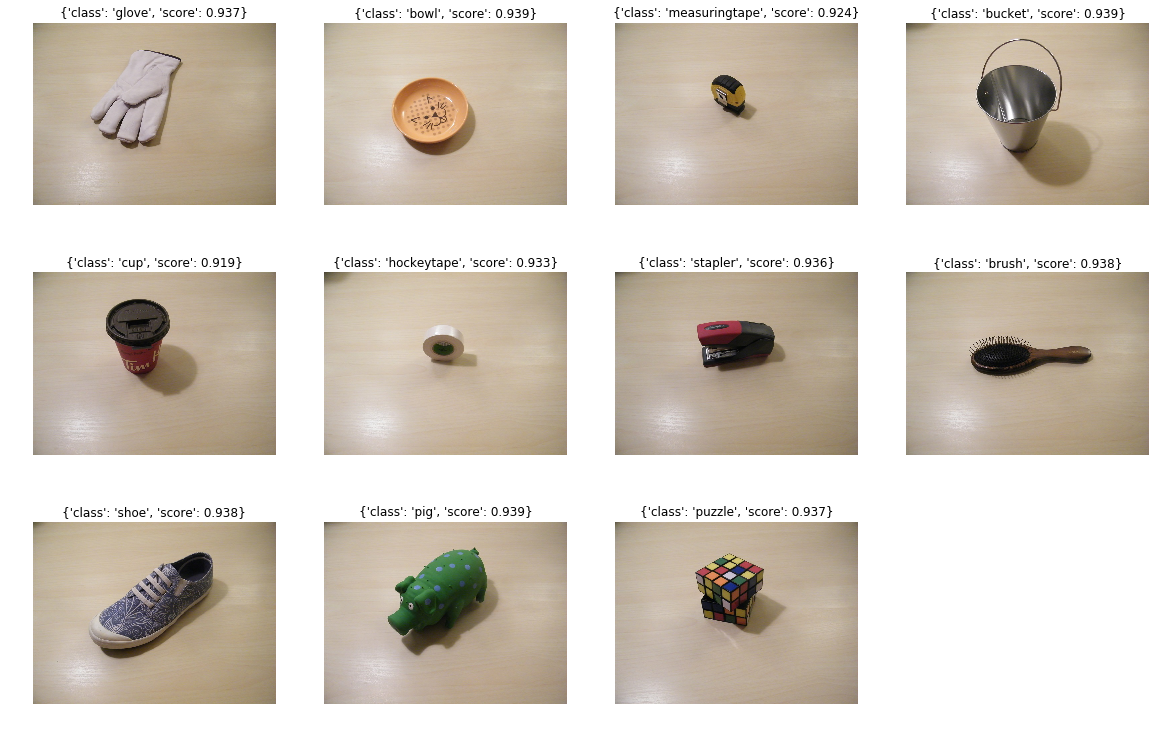

In [25]:
import matplotlib.pyplot as plt
from skimage import io
fig, axs = plt.subplots( 3, 4, figsize=( 20, 13 ) )
results_copy = results.copy()
for i in range(3):
    for j in range(4):
        if len( results_copy ) > 0:
            result = results_copy.pop()
            axs[i,j].imshow( io.imread( result["url"] ) )
            axs[i,j].set_title( result["top_class"] )
        axs[i,j].axis('off')

# Section B. Prototype some app code

To use this model in an application, we need to figure out how to take an image given to the app, and then send that image to the model for classification.

### 2.1 Download a test image

Above, we sent the URL of the test images to the model for classification.  In the case of an app, we'd have a local file, not a URL.  So, first thing to do here is download a test image to the notebook working directory.

In [ ]:
!pip install wget

In [27]:
import wget
url = "https://github.com/IBMDataScience/Watson-Studio-Examples/raw/master/Scavenger-hunt-BINGO/indoor-scavenger-hunt-model/test_images/DSCF3923.jpg"
filename = wget.download( url )
!ls -l

total 100
-rw-r----- 1 dsxuser dsxuser 101485 Feb 24 03:06 DSCF3923.jpg


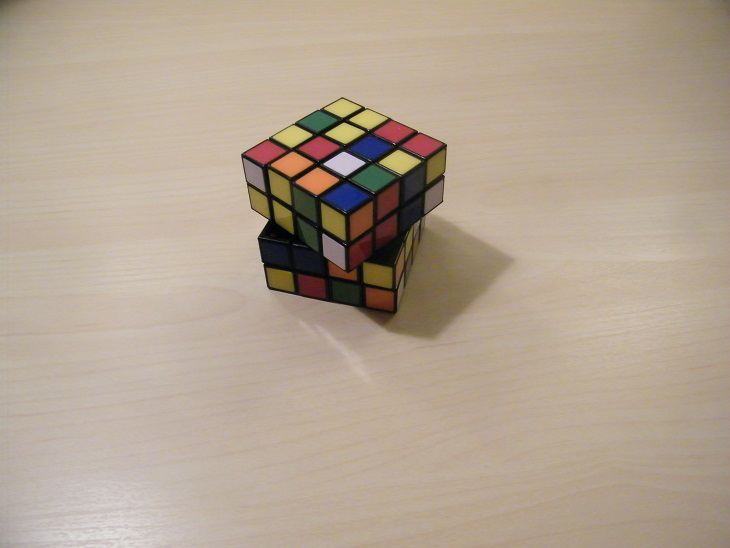

In [28]:
from PIL import Image
img = Image.open( filename )
img

### 2.2 Resize the image

Apps often have to preprocess data "from the wild" before sending the data to a model for analysis.

In the case of our app, because the imaage from a tyical phone camera is quite large, we can make the image smaller to make it faster to send to the model.

In [29]:
import re
def resizeImage( org_filename ):
    img = Image.open( org_filename )
    img.thumbnail( ( 224, 224 ), Image.ANTIALIAS )
    file_base_name = re.sub( "\..*$", "", org_filename )
    file_extension = re.sub( ".*\.", "", org_filename )
    sm_filename = file_base_name + "_sm." + file_extension
    img.save( sm_filename )
    return sm_filename

DSCF3923_sm.jpg


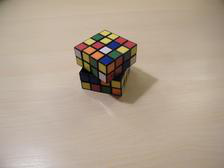

In [30]:
sm_img_filename = resizeImage( filename )
print( sm_img_filename )
Image.open( sm_img_filename )

### 2.3 Classify the smaller image from the file

Rework the `classifyImage_url` function, created above, to send a file for classification.

In [31]:
def classifyImage( image_filename ):
    with open( image_filename, "rb" ) as image_file:
        results = visual_recognition.classify( image_file, threshold="0", classifier_ids=model_id ).get_result()
        print( "Results:" )
        print( json.dumps( results, indent=3 ) )
        top_class = getTopClass( results )
        return { "top_class" : top_class, "results" : results }

In [32]:
classifyImage( sm_img_filename )

Results:
{
   "images": [
      {
         "classifiers": [
            {
               "classes": [
                  {
                     "class": "bowl",
                     "score": 0
                  },
                  {
                     "class": "brush",
                     "score": 0
                  },
                  {
                     "class": "bucket",
                     "score": 0.001
                  },
                  {
                     "class": "cup",
                     "score": 0.001
                  },
                  {
                     "class": "glove",
                     "score": 0
                  },
                  {
                     "class": "hockeytape",
                     "score": 0
                  },
                  {
                     "class": "measuringtape",
                     "score": 0
                  },
                  {
                     "class": "pig",
                     "score": 0
      

{'results': {'custom_classes': 11,
  'images': [{'classifiers': [{'classes': [{'class': 'bowl', 'score': 0},
       {'class': 'brush', 'score': 0},
       {'class': 'bucket', 'score': 0.001},
       {'class': 'cup', 'score': 0.001},
       {'class': 'glove', 'score': 0},
       {'class': 'hockeytape', 'score': 0},
       {'class': 'measuringtape', 'score': 0},
       {'class': 'pig', 'score': 0},
       {'class': 'puzzle', 'score': 0.939},
       {'class': 'shoe', 'score': 0},
       {'class': 'stapler', 'score': 0.001}],
      'classifier_id': 'indoorxscavengerxhunt_675080809',
      'name': 'indoor-scavenger-hunt'}],
    'image': 'DSCF3923_sm.jpg'}],
  'images_processed': 1},
 'top_class': {'class': 'puzzle', 'score': 0.939}}

### Author

**Sarah Packowski** is a Content Designer for Watson Studio.

<hr>
Copyright © 2019 IBM. This notebook and its source code are released under the terms of the MIT License.

<div style="background:#F5F7FA; height:110px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Love this notebook? </span>
<span style="font-size:15px;color:#152935;float:right;margin-right:40px;">Don't have an account yet?</span><br>
<span style="color:#5A6872;">Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style="border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;"><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
</div>